In [225]:
import MetaTrader5 as mt5
from tqdm import tqdm
import time

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay

from datetime import datetime, timedelta
from itertools import combinations, count

from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller

from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

from keras.models import Sequential
from keras.models import Sequential
from keras.layers import LSTM, Dense

from scipy.stats import entropy
from sklearn.metrics import mean_absolute_error, mean_squared_error

import vectorbt as vbt

In [77]:
# get all symbols from the location specified
def get_symbols(location):
    mt5.initialize()

    symbol_list = []
    for symbol in mt5.symbols_get():
        if location in symbol.path:
            symbol_list.append(symbol.name)

    return symbol_list

In [78]:
# For start_date to end_date get the 1 hour ticker info for symbol
def get_bars_from_broker(symbol, start_date, end_date, timeframe=mt5.TIMEFRAME_H1):
    mt5.initialize()
    bars = mt5.copy_rates_range(symbol, timeframe, start_date, end_date)
    df_bars = pd.DataFrame(bars)
    df_bars["time"] = pd.to_datetime(df_bars["time"], unit="s")
    return df_bars

In [79]:
mt5.initialize()

True

In [80]:
# How many days worth of data to consider
LOOKBACK = 300

end_date = datetime.now() + timedelta(hours=3) # The '+ timedelta(hours=3)' is here because of some unknown time-lag issues with metatrader5
start_date = end_date - BDay(LOOKBACK)

In [108]:
# 1 Get Asset Universe
location = "Retail\\Stocks\\Germany"

In [109]:
# Create a list of all available tradable assets in the chosen location
symbol_list = []
for symbol in mt5.symbols_get():
    if location in symbol.path:
        symbol_list.append(symbol.name)

In [110]:
symbol_close_data = {}
# For each symbol
for symbol in tqdm(symbol_list):
    # get the OHLC data from the broker
    bar_data = get_bars_from_broker(symbol, start_date, end_date)

    # Store the data locally so we dont have to request the same
    # data from the broker everytime we use it. 
    bar_data.to_csv(f'historic_data/{symbol}.csv', index=False)

100%|██████████| 83/83 [00:06<00:00, 13.19it/s]


In [111]:
# Specify the basket size
BASKET_SIZE = 2 # Keep the basket to pairs trading: too expensive without parallelization 

# Create a new list whose elements are pairs of assets
symbol_basket_collection = list(combinations(symbol_list, BASKET_SIZE))
print(f'The collection has {len(symbol_basket_collection)} baskets of assets')

The collection has 3403 baskets of assets


In [112]:
def check_cointegration(symbol_basket, total_baskets):
    # Read the OHLC data from CSV files
    data = [pd.read_csv(f'historic_data/{symbol}.csv') for symbol in symbol_basket]

    ##########################################################
    # This section equalizes the length of the time series

    # Find the minimum length among the dataframes
    min_length = min(len(df) for df in data)

    # Truncate dataframes to the minimum length
    data = [df.head(min_length) for df in data]

    # Update CSV files if required
    
    for symbol, df in zip(symbol_basket, data):
        df.to_csv(f'historic_data/{symbol}.csv', index=False)

    ##########################################################

    # Extract the close prices
    close_prices = np.column_stack([df['close'] for df in data])

    # Apply Johansen test
    johansen_test = coint_johansen(close_prices, det_order=0, k_ar_diff=1)

    # Standard alpha value 
    alpha = 0.05

    # Adjust alpha for Bonferroni correction
    bonferroni_alpha = alpha / total_baskets

    # Check cointegration using the Bonferroni-adjusted alpha
    is_cointegrated = any(johansen_test.lr1 > johansen_test.cvt[:, 1]) and (1 - bonferroni_alpha) > 0.95

    # Get the cointegration coefficients (eigenvectors)
    cointegration_coefficients = johansen_test.evec[:, 0]

    return is_cointegrated, cointegration_coefficients.tolist()

In [113]:
def find_cointegrated_assets(symbol_baskets_collection):
    cointegrated_assets = []
    total_baskets = len(symbol_baskets_collection)
    
    for basket in tqdm(symbol_baskets_collection):

        # return (Boolean, List<COEFF>) 
        is_cointegrated, coefficients = check_cointegration(basket, total_baskets)

        # If they are cointegrated
        if is_cointegrated:

            # Load their OHLC
            data = [pd.read_csv(f'historic_data/{symbol}.csv') for symbol in basket]

            # Create the (stationary) time series from their close data using the cointegration coefficients
            combined_asset = sum(df['close'] * coeff for df, coeff in zip(data, coefficients))

            # append to the list of cointegrated assets
            cointegrated_assets.append((basket, combined_asset))
            
    return cointegrated_assets

In [114]:
cointegrated_assets = find_cointegrated_assets(symbol_basket_collection)

100%|██████████| 3403/3403 [02:27<00:00, 23.01it/s]


In [115]:
def test_stationarity_of_assets(cointegrated_assets):
    stationary_assets = []

    for asset in tqdm(cointegrated_assets):
        asset_name, time_series = asset

        # Applying the ADF test
        result = adfuller(time_series)

        # Extracting the p-value
        p_value = result[1]

        # Stationarity criteria: p-value should be less than or equal to 0.05
        if p_value <= 0.05:
            stationary_assets.append((asset_name, time_series))

    return stationary_assets

In [116]:
stationary_assets = test_stationarity_of_assets(cointegrated_assets)

100%|██████████| 1000/1000 [00:54<00:00, 18.35it/s]


In [117]:
def hurst_exponent(time_series):
    
    # Define the range of lags
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(time_series[lag:], time_series[:-lag]))) for lag in lags]

    # To avoid divide by zero error, add a small constant to tau values
    tau = np.array(tau) + 1e-10

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # The Hurst exponent is half of the slope of the linear fit
    return poly[0] * 0.5

def check_mean_reversion(stationary_assets):
    
    mean_reverting_assets = []

    for asset in tqdm(stationary_assets):
        asset_name, time_series = asset

        # Calculate the Hurst exponent for the time series
        H = hurst_exponent(time_series)

        # Check if the Hurst exponent indicates mean reversion (0 < H < 0.5)
        if 0 < H < 0.5:
            mean_reverting_assets.append(asset)

    return mean_reverting_assets

In [118]:
mean_reverting_assets = check_mean_reversion(stationary_assets)

100%|██████████| 559/559 [00:24<00:00, 23.25it/s]


In [119]:
def calculate_half_life(time_series):
    # Prepare the data for linear regression
    ts_diff = np.diff(time_series)
    ts_lagged = time_series[:-1]

    # Perform linear regression
    ts_lagged_const = add_constant(ts_lagged)
    model = OLS(ts_diff, ts_lagged_const)
    result = model.fit()

    # Calculate theta from the regression coefficient
    theta = -result.params[1]

    # Calculate and return half-life
    half_life = np.log(2) / theta
    return half_life

def calculate_half_lives(mean_reverting_assets):
    results = []

    for asset in tqdm(mean_reverting_assets):
        asset_name, time_series = asset

        # Calculate half-life
        half_life = calculate_half_life(time_series)
        results.append((asset_name, time_series, half_life))

    return results

In [120]:
half_life_assets = calculate_half_lives(mean_reverting_assets)

100%|██████████| 559/559 [00:00<00:00, 724.34it/s]


In [121]:
def find_fastest_half_life_asset(half_life_assets):
    if not half_life_assets:
        return None

    # Initialize with the first asset's data
    fastest_asset = half_life_assets[0]

    for asset in half_life_assets:
        _, _, half_life = asset

        # Compare with the current minimum half-life
        if half_life < fastest_asset[2]:
            fastest_asset = asset

    return fastest_asset

In [122]:
fastest_half_life_asset = find_fastest_half_life_asset(half_life_assets)

In [244]:
def plot_asset(asset):
    # Unpack the asset data
    asset_name, time_series, _ = asset

    # Plotting the time series
    plt.figure(figsize=(15, 5))
    
    plt.plot(time_series)

    plt.axhline(time_series.mean(), color='g', label='mean')
    
    plt.axhline(time_series.mean() + time_series.std(), color='y', label='+std')
    plt.axhline(time_series.mean() - time_series.std(), color='y', label='-std')
    
    plt.axhline(time_series.mean() + 2 * time_series.std(), color='r', label='+stop loss')
    plt.axhline(time_series.mean() - 2 * time_series.std(), color='r', label='-stop loss')

    plt.legend(loc="upper right")

    plt.ylim(time_series.mean() - 5 * time_series.std(), time_series.mean() + 5 * time_series.std())

    plt.title(f'Time Series Plot for {asset_name}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

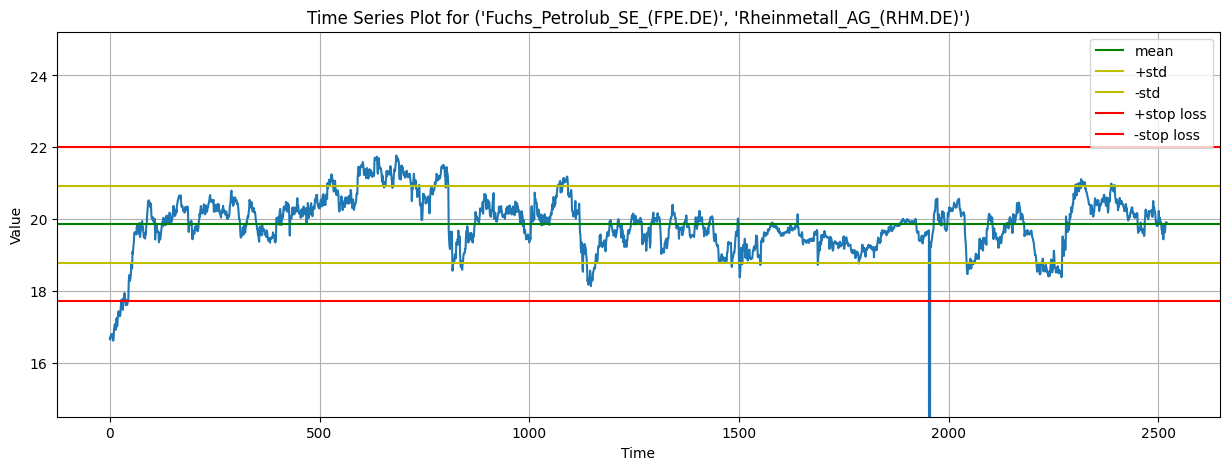

2521


In [245]:
plot_asset(fastest_half_life_asset)
print(len(fastest_half_life_asset[1]))

In [137]:
fastest_half_life_asset[0]

('Fuchs_Petrolub_SE_(FPE.DE)', 'Rheinmetall_AG_(RHM.DE)')

In [126]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


In [171]:
HISTORY_LENGTH = 50
FORECAST_DISTANCE = round(4 * fastest_half_life_asset[2]) 
print(FORECAST_DISTANCE)

11


In [215]:
# Determine the split point
split_point = int(len(fastest_half_life_asset[1]) * 0.7)

# Split the data
training_data = fastest_half_life_asset[1][:split_point]
testing_data = fastest_half_life_asset[1][split_point:]

# Determine the validation split point
val_split_point = int(len(training_data) * 0.7)

validation_data = training_data[:val_split_point]
training_data = training_data[val_split_point:]

# Prepare input data for training
X_train, y_train = split_sequence(training_data.to_list(), n_steps_in=HISTORY_LENGTH, n_steps_out=FORECAST_DISTANCE)

# Prepare input data for validation
X_val, y_val = split_sequence(validation_data.to_list(), n_steps_in=HISTORY_LENGTH, n_steps_out=FORECAST_DISTANCE)

In [216]:
# Define the model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(HISTORY_LENGTH, 1)))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(30, activation='relu', return_sequences=True))
model.add(LSTM(20, activation='relu', return_sequences=True))
model.add(LSTM(10, activation='relu'))
model.add(Dense(FORECAST_DISTANCE))
model.compile(optimizer='adam', loss='mse')

# Fit model with training and validation data
history = model.fit(X_train, y_train, epochs=200, verbose=1, validation_data=(X_val, y_val))

Epoch 1/200
15/15 [==============================] - 6s 147ms/step - loss: 1669.9133 - val_loss: 553.6477
Epoch 2/200
15/15 [==============================] - 2s 113ms/step - loss: 474.4359 - val_loss: 36686.5195
Epoch 3/200
15/15 [==============================] - 2s 114ms/step - loss: 9297.4092 - val_loss: 1257.7289
Epoch 4/200
15/15 [==============================] - 2s 113ms/step - loss: 68909.6094 - val_loss: 1158.3168
Epoch 5/200
15/15 [==============================] - 2s 113ms/step - loss: 617.4854 - val_loss: 715.9500
Epoch 6/200
15/15 [==============================] - 2s 112ms/step - loss: 551.3902 - val_loss: 428.2386
Epoch 7/200
15/15 [==============================] - 2s 121ms/step - loss: 399.3813 - val_loss: 429.9229
Epoch 8/200
15/15 [==============================] - 2s 115ms/step - loss: 398.5128 - val_loss: 426.1970
Epoch 9/200
15/15 [==============================] - 2s 123ms/step - loss: 395.5114 - val_loss: 423.2734
Epoch 10/200
15/15 [===========================

Average training loss: 459.2468746650219
Average validation loss: 261.94921556651593


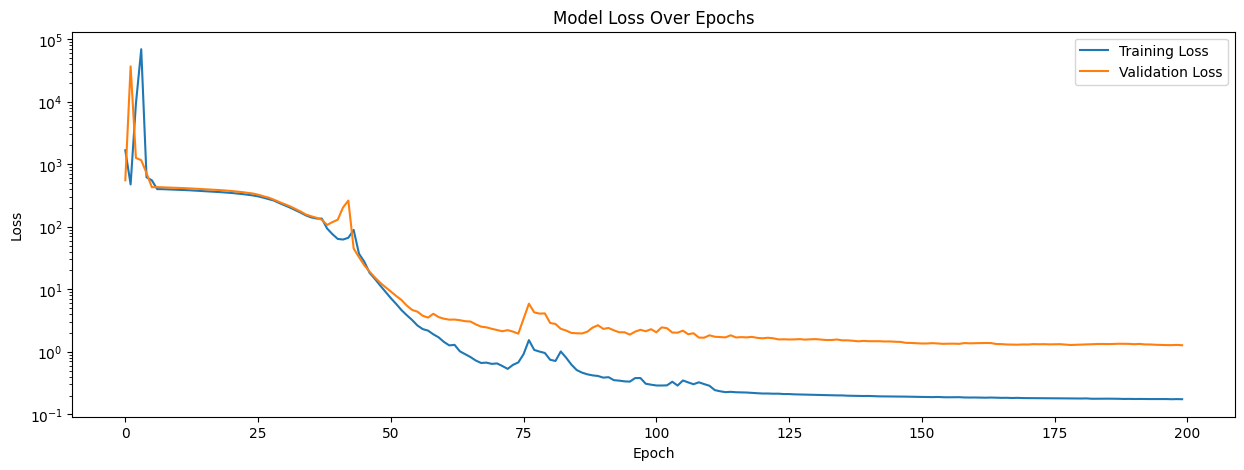

In [222]:
# Plotting the training and validation loss

print(f'Average training loss: {np.array(history.history["loss"]).mean()}')
print(f'Average validation loss: {np.array(history.history["val_loss"]).mean()}')
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.yscale('log')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Mean Absolute Error (MAE): 1.0699303641781819
Root Mean Squared Error (RMSE): 2.148646559486282


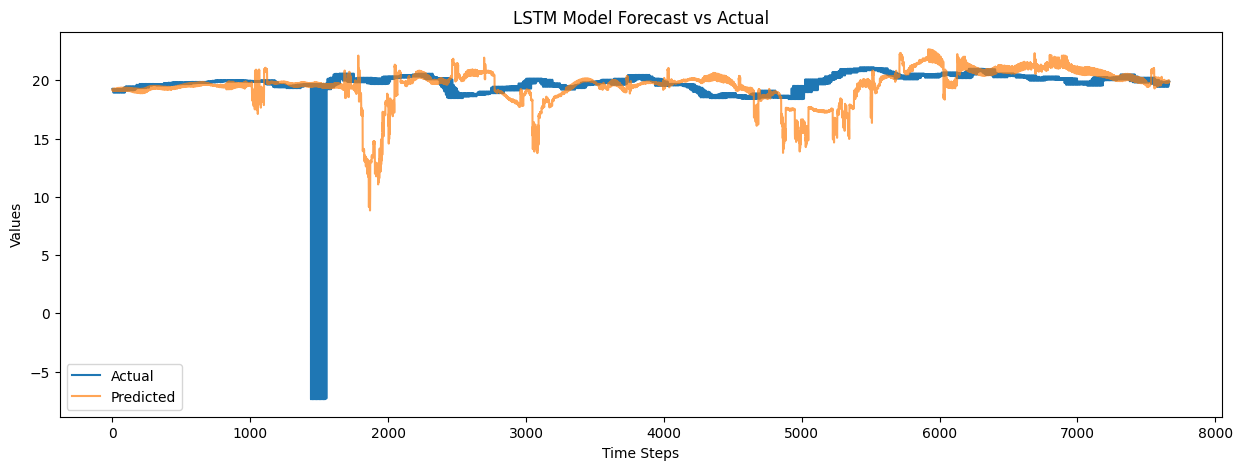

In [226]:
# Prepare the test data in the same format
X_test, y_test = split_sequence(testing_data.to_list(), n_steps_in=HISTORY_LENGTH, n_steps_out=FORECAST_DISTANCE)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


# Make predictions
predictions = model.predict(X_test, verbose=0)

# Calculate accuracy metrics
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Plotting the performance
plt.figure(figsize=(15, 5))
plt.plot(y_test.flatten(), label='Actual')
plt.plot(predictions.flatten(), label='Predicted', alpha=0.7)
plt.title('LSTM Model Forecast vs Actual')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()

In [227]:
# Function to calculate KL divergence
def calculate_kl_divergence(actual_series, forecasted_series):
    actual_series_prob = np.histogram(actual_series, bins=10, density=True)[0]
    forecasted_series_prob = np.histogram(forecasted_series, bins=10, density=True)[0]

    actual_series_prob += 1e-15
    forecasted_series_prob += 1e-15

    kl_div = entropy(forecasted_series_prob, actual_series_prob)

    return kl_div

In [228]:
kl_divergence = calculate_kl_divergence(y_test.flatten(), predictions.flatten())
print(f"KL Divergence: {kl_divergence}")

KL Divergence: 29.899188914663725


In [231]:
def backtest(asset, model, history_length):

    time_series = asset

    # Positions are encoded as follows
    HIGH = 1
    FREE = 0
    LOW = -1

    mean = time_series.mean()
    std = time_series.std()

    tp = mean
    high_entry = mean + (std)
    low_entry = mean - (std)

    high_sl = mean + (2 * std)
    low_sl = mean - (2 * std)


    entries = [False for i in range(len(time_series))]
    exits = [False for i in range(len(time_series))]

    position_type = FREE

    for t in range(history_length, len(time_series)):
        # Trade!
        if position_type == FREE:
            if time_series.iloc[t - 1] < high_entry <= time_series.iloc[t]:
                
                x_input = np.array(time_series[t-history_length:t]).reshape(-1)
                x_input = x_input.reshape((1, HISTORY_LENGTH, 1))
                
                if min(model.predict(x_input, verbose=0)[0]) < tp:
                    # Short first Long last
                    entries[t] = True
                    position_type = HIGH

            elif time_series.iloc[t - 1] > low_entry >= time_series.iloc[t]:

                x_input = np.array(time_series[t-history_length:t]).reshape(-1)
                x_input = x_input.reshape((1, HISTORY_LENGTH, 1))
                
                if max(model.predict(x_input, verbose=0)[0]) > tp:

                    # Long first Short last
                    entries[t] = True
                    position_type = LOW

        elif position_type == HIGH:
            if time_series.iloc[t - 1] > tp >= time_series.iloc[t]:
                exits[t] = True
                position_type = FREE
            elif time_series.iloc[t - 1] < high_sl <= time_series.iloc[t]:
                exits[t] = True
                position_type = FREE
        elif position_type == LOW:
            if time_series.iloc[t - 1] < tp <= time_series.iloc[t]:
                exits[t] = True
                position_type = FREE
            elif time_series.iloc[t - 1] > low_sl >= time_series.iloc[t]:
                exits[t] = True
                position_type = FREE

    return entries, exits

In [232]:
entries, exits = backtest(fastest_half_life_asset[1], model, history_length=HISTORY_LENGTH)

In [236]:
pf = vbt.Portfolio.from_signals(
        fastest_half_life_asset[1], 
        entries, 
        exits,
        freq='1h'
    )

In [237]:
pf.stats()

Start                                         0
End                                        2520
Period                        105 days 01:00:00
Start Value                               100.0
End Value                            122.752199
Total Return [%]                      22.752199
Benchmark Return [%]                -312.725191
Max Gross Exposure [%]                    100.0
Total Fees Paid                             0.0
Max Drawdown [%]                      11.375445
Max Drawdown Duration          32 days 22:00:00
Total Trades                                  9
Total Closed Trades                           9
Total Open Trades                             0
Open Trade PnL                              0.0
Win Rate [%]                          66.666667
Best Trade [%]                         7.524513
Worst Trade [%]                       -6.358738
Avg Winning Trade [%]                  6.776372
Avg Losing Trade [%]                  -6.083401
Avg Winning Trade Duration      3 days 0

In [238]:
pf.plot().show()

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Function to download stock data
def download_data(stock_ticker, start_date, end_date):
    stock_data = yf.download(stock_ticker, start=start_date, end=end_date)
    monthly_prices = stock_data['Adj Close'].resample('M').last()
    monthly_returns = monthly_prices.pct_change().dropna()
    return monthly_returns

# Function to download Fama-French factors
def download_ff_factors(start_date, end_date):
    # Link to Fama-French factors
    ff_factors_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"
    ff_factors = pd.read_csv(ff_factors_url, skiprows=3)
    ff_factors['Date'] = pd.to_datetime(ff_factors['Date'], format='%Y%m')
    ff_factors.set_index('Date', inplace=True)
    ff_factors = ff_factors[start_date:end_date]
    ff_factors = ff_factors / 100  # Scale to proper format
    return ff_factors

# Download data
start_date = '2018-01-01'
end_date = '2023-01-01'
goog_returns = download_data('GOOG', start_date, end_date)
ff_factors = download_ff_factors(start_date, end_date)

# Align the data
data = pd.concat([goog_returns, ff_factors], axis=1).dropna()
data.columns = ['GOOG', 'Mkt-RF', 'SMB', 'HML', 'RF']

# Calculate excess returns for GOOG
data['Excess_GOOG'] = data['GOOG'] - data['RF']

# Define independent variables (market excess return, SMB, HML) and dependent variable (GOOG excess return)
X = data[['Mkt-RF', 'SMB', 'HML']]
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = data['Excess_GOOG']

# Run the regression
model = sm.OLS(y, X).fit()
print(model.summary())

# Plotting the fitted values vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(data.index, y, color='blue', label='Actual Excess Returns')
plt.plot(data.index, model.fittedvalues, color='red', label='Fitted Excess Returns')
plt.title('Fama-French 3-Factor Model Fitted vs Actual Excess Returns')
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed


KeyError: 'Date'